# Traitement didactique des données tractométriques: Exemple CST_right

Ce notebook illustre de bout en bout un flux de nettoyage, contrôle qualité, transformation et analyses statistiques sur le faisceau CST droit (CST_right) à partir des fichiers produits par le pipeline actiDep. Chaque section est indépendante et montre les bonnes pratiques reproductibles.

> NOTE: Adaptez les chemins `db_root` et filtres si votre environnement diffère. Le but ici est pédagogique: certaines étapes (dates, catégories, etc.) sont illustrées même si non pertinentes pour toutes les colonnes réelles.

## 1. Chargement des données
### 1.1 Paramètres de base

In [1]:
# Paramètres de base
import os, json, hashlib, textwrap, datetime
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

from actiDep.data.loader import Actidep
from actiDep.set_config import get_HCP_bundle_names

DB_ROOT = Path('/home/ndecaux/NAS_EMPENN/share/projects/actidep/bids')  # adapter si besoin
PIPELINE = 'hcp_association_24pts'
BUNDLE_KEY = 'AFleft'  # clé interne (colonne entities bundle)

### 1.2 Chargement des fichiers CSV

In [2]:
# Chargement des fichiers csv correspondant aux métriques tractométriques
actidep_ds = Actidep(str(DB_ROOT))
all_metric_files = actidep_ds.get_global(pipeline=PIPELINE, extension='csv', datatype='metric')

bundle_files = [f for f in all_metric_files if f.get_entities().get('bundle') == BUNDLE_KEY]
print(f"Fichiers trouvés pour {BUNDLE_KEY}: {len(bundle_files)}")
for f in bundle_files[:5]:
    print('-', f.path)

# Chargement concaténé
dfs = []
for f in bundle_files:
    df = pd.read_csv(f.path)
    df['subject'] = f.get_full_entities()['subject']
    df['participant_id'] = 'sub-' + df['subject'].astype(str)
    dfs.append(df)
raw_df = pd.concat(dfs, ignore_index=True)
print(raw_df.shape)
raw_df.head()

Fichiers trouvés pour AFleft: 59
- /home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/derivatives/hcp_association_24pts/sub-01002/metric/sub-01002_bundle-AFleft_desc-cleaned_model-MCM_space-HCP_mean.csv
- /home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/derivatives/hcp_association_24pts/sub-01016/metric/sub-01016_bundle-AFleft_desc-cleaned_model-MCM_space-HCP_mean.csv
- /home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/derivatives/hcp_association_24pts/sub-01042/metric/sub-01042_bundle-AFleft_desc-cleaned_model-MCM_space-HCP_mean.csv
- /home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/derivatives/hcp_association_24pts/sub-01037/metric/sub-01037_bundle-AFleft_desc-cleaned_model-MCM_space-HCP_mean.csv
- /home/ndecaux/NAS_EMPENN/share/projects/actidep/bids/derivatives/hcp_association_24pts/sub-01029/metric/sub-01029_bundle-AFleft_desc-cleaned_model-MCM_space-HCP_mean.csv
(1416, 10)


,centroid_id,point_id,AD,RD,MD,FA,IFW,IRF,subject,participant_id
0,0,0,0.000824,0.000252,0.000442,0.656616,0.386652,0.190005,01002,sub-01002
1,0,1,0.000832,0.000248,0.000443,0.659676,0.220109,0.213511,01002,sub-01002
2,0,2,0.000775,0.000174,0.000374,0.760132,0.189293,0.261940,01002,sub-01002
3,0,3,0.000758,0.000184,0.000375,0.739671,0.192381,0.243734,01002,sub-01002
4,0,4,0.000852,0.000184,0.000407,0.754936,0.188530,0.224630,01002,sub-01002


## 2. Inspection rapide des données
### 2.1 Aperçu des colonnes et métadonnées

In [3]:
print('Aperçu colonnes:', list(raw_df.columns))
raw_df.info()
raw_df.describe(include='all').T.head(20)

Aperçu colonnes: ['centroid_id', 'point_id', 'AD', 'RD', 'MD', 'FA', 'IFW', 'IRF', 'subject', 'participant_id']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   centroid_id     1416 non-null   int64  
 1   point_id        1416 non-null   int64  
 2   AD              1389 non-null   float64
 3   RD              1389 non-null   float64
 4   MD              1389 non-null   float64
 5   FA              1389 non-null   float64
 6   IFW             1389 non-null   float64
 7   IRF             1389 non-null   float64
 8   subject         1416 non-null   object 
 9   participant_id  1416 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 110.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
centroid_id,1416.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
point_id,1416.0,NaN,NaN,NaN,11.5,6.924632,0.0,5.75,11.5,17.25,23.0
AD,1389.0,NaN,NaN,NaN,0.000871,0.000154,0.000278,0.000766,0.000842,0.000962,0.001432
RD,1389.0,NaN,NaN,NaN,0.000187,0.000054,0.000011,0.000151,0.00018,0.000218,0.000491
MD,1389.0,NaN,NaN,NaN,0.000415,0.000057,0.0001,0.000381,0.000415,0.000448,0.000689
FA,1389.0,NaN,NaN,NaN,0.747278,0.077595,0.385006,0.700182,0.755634,0.7999,0.968986
IFW,1389.0,NaN,NaN,NaN,0.216355,0.052918,0.088407,0.184676,0.205142,0.230057,0.559442
IRF,1389.0,NaN,NaN,NaN,0.164395,0.084589,0.001518,0.097481,0.150778,0.221956,0.615111
subject,1416,59,01002,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant_id,1416,59,sub-01002,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Préparation des données
### 3.1 Définition du schéma attendu

In [4]:
# Section 3: Schéma attendu
metric_cols = [c for c in ['FA','MD','RD','AD','IFW','IRF'] if c in raw_df.columns]
SCHEMA = {
    'subject': {'type':'str','nullable':False},
    'point_id': {'type':'int','nullable':False},
    **{m:{'type':'float','nullable':True} for m in metric_cols}
}
print('Schéma attendu (simplifié):')
for k,v in SCHEMA.items():
    print('-', k, v)

Schéma attendu (simplifié):
- subject {'type': 'str', 'nullable': False}
- point_id {'type': 'int', 'nullable': False}
- FA {'type': 'float', 'nullable': True}
- MD {'type': 'float', 'nullable': True}
- RD {'type': 'float', 'nullable': True}
- AD {'type': 'float', 'nullable': True}
- IFW {'type': 'float', 'nullable': True}
- IRF {'type': 'float', 'nullable': True}


### 3.2 Audit de qualité des données

In [5]:
# Section 4: Audit qualité
quality_rows = []
for col in ['subject','point_id', *metric_cols]:
    s = raw_df[col]
    quality_rows.append({
        'col': col,
        'dtype_actual': str(s.dtype),
        'n': s.shape[0],
        'n_null': int(s.isna().sum()),
        'pct_null': s.isna().mean(),
        'n_unique': s.nunique(dropna=True),
        'sample_values': s.dropna().unique()[:5]
    })
quality_df = pd.DataFrame(quality_rows)
quality_df

,col,dtype_actual,n,n_null,pct_null,n_unique,sample_values
0,subject,object,1416,0,0.000000,59,"[01002, 01016, 01042, 01037, 01029]"
1,point_id,int64,1416,0,0.000000,24,"[0, 1, 2, 3, 4]"
2,FA,float64,1416,27,0.019068,1389,"[0.6566161814947872, 0.6596757535379318, 0.760..."
3,MD,float64,1416,27,0.019068,1389,"[0.0004424403813745, 0.0004428248796384, 0.000..."
4,RD,float64,1416,27,0.019068,1389,"[0.0002518117269952, 0.000248141451619, 0.0001..."
5,AD,float64,1416,27,0.019068,1389,"[0.0008236976901335, 0.0008321917356782, 0.000..."
6,IFW,float64,1416,27,0.019068,1389,"[0.3866524857639559, 0.2201087183955467, 0.189..."
7,IRF,float64,1416,27,0.019068,1389,"[0.1900046949616068, 0.2135109689346293, 0.261..."


### 3.3 Nettoyage des valeurs manquantes

In [7]:
# Section 6: Nettoyage valeurs manquantes (logique similaire à generate_report_v2.clean_missing_data)
# Pivot pour repérer points très manquants
pivot = raw_df.pivot_table(index='subject', columns='point_id', values=metric_cols[0], aggfunc='mean')
prop_nan_point = pivot.isna().sum()/pivot.shape[0]
POINT_DROP = sorted(prop_nan_point[prop_nan_point>=0.15].index.tolist())
print('Points supprimés (>=15% NaN):', POINT_DROP)
clean_df = raw_df[~raw_df['point_id'].isin(POINT_DROP)].copy()
# Retrait sujets ayant encore NaN sur métrique principale
pivot2 = clean_df.pivot_table(index='subject', columns='point_id', values=metric_cols[0], aggfunc='mean')
SUBJECT_DROP = pivot2.index[pivot2.isna().any(axis=1)].tolist()
print('Sujets supprimés (NaN résiduels):', SUBJECT_DROP, '(Nb:', len(SUBJECT_DROP), ')')
clean_df = clean_df[~clean_df['subject'].isin(SUBJECT_DROP)].copy()

Points supprimés (>=15% NaN): [23]
Sujets supprimés (NaN résiduels): ['01014', '01020', '01023', '01025', '01038', '01044', '03008', '03013'] (Nb: 8 )


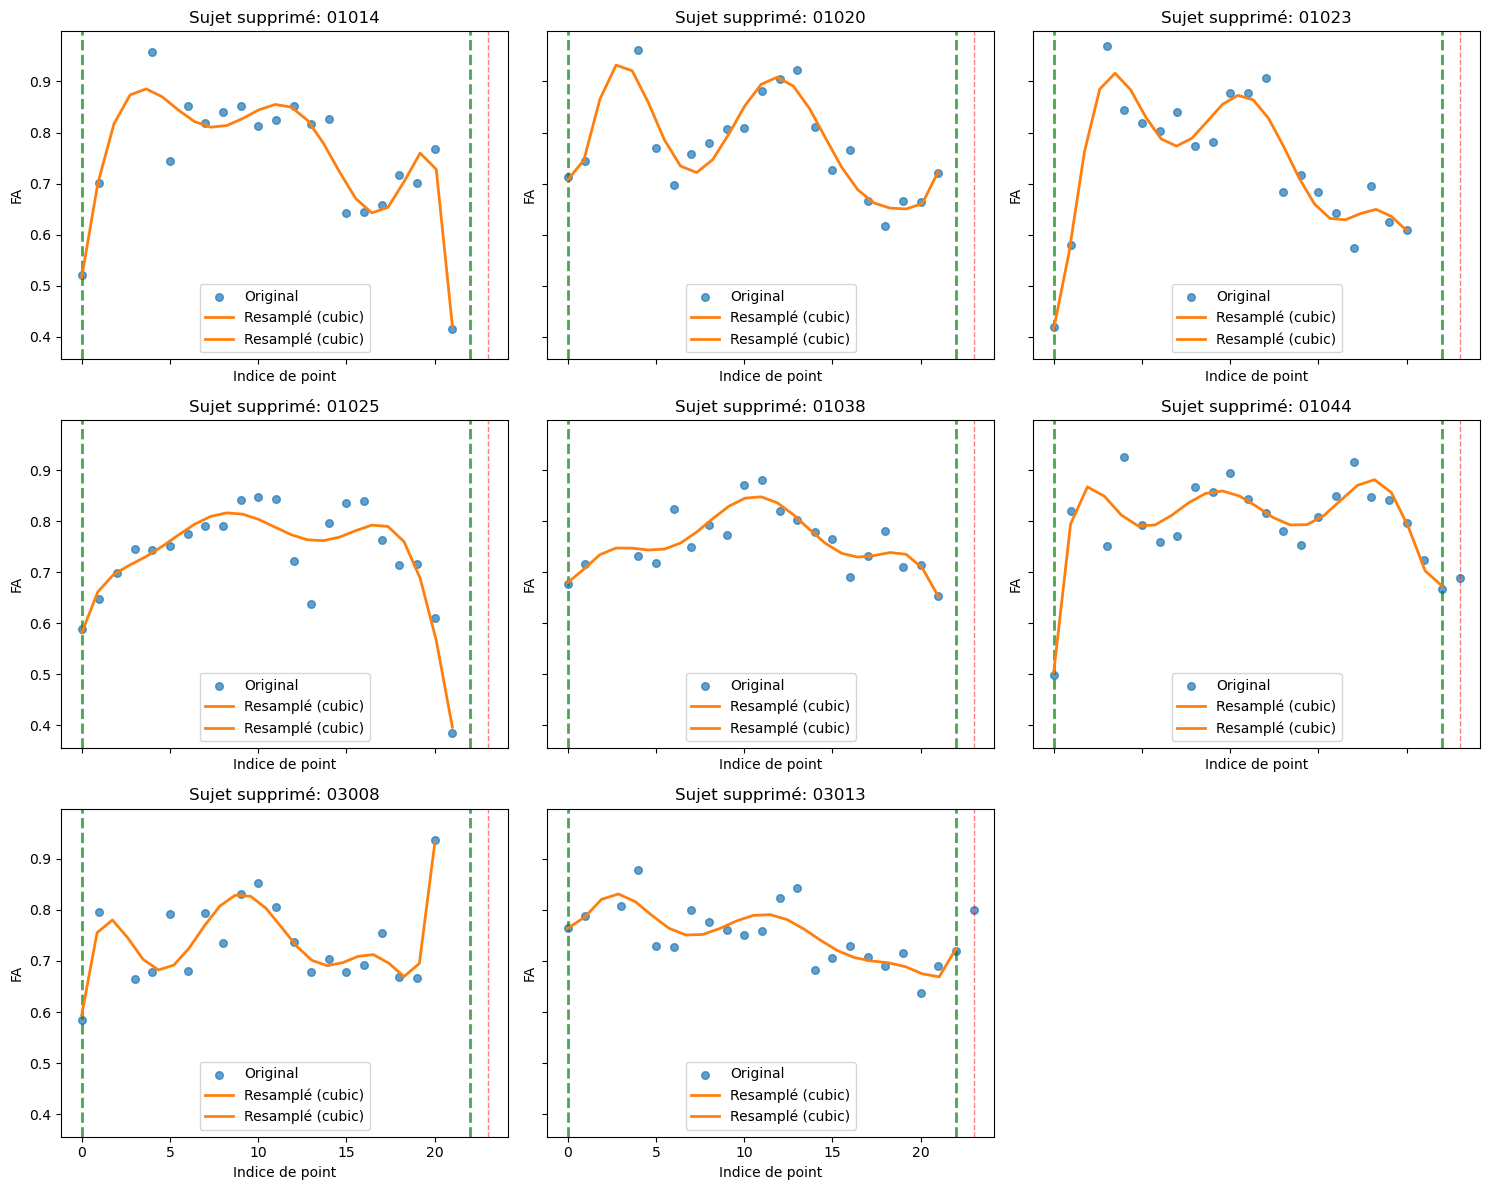

In [8]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from numpy import polyfit
n = len(SUBJECT_DROP)
if n == 0:
    print("Aucun sujet supprimé à afficher.")
else:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, subject in enumerate(SUBJECT_DROP):
        group = raw_df[raw_df['subject'] == subject]
        x = group['point_id'].values
        y = group['FA'].values

        # Détection des indices de points non supprimés
        mask = ~np.isin(x, POINT_DROP)
        x_valid = x[mask]
        y_valid = y[mask]

        # Trouver le plus grand segment continu de points non supprimés
        if len(x_valid) == 0:
            axes[i].set_title(f"Sujet supprimé: {subject}\nAucun segment valide")
            axes[i].axis('off')
            continue

        # Ordonner les points
        idx_sort = np.argsort(x_valid)
        x_valid_sorted = x_valid[idx_sort]
        y_valid_sorted = y_valid[idx_sort]

        # Trouver les coupures (là où la différence > 1)
        diffs = np.diff(x_valid_sorted)
        split_idx = np.where(diffs > 1)[0]

        # Définir les bornes des segments
        segments = []
        start = 0
        for idx in split_idx:
            end = idx + 1
            segments.append((start, end))
            start = end
        segments.append((start, len(x_valid_sorted)))

        # Trouver le segment le plus long
        seg_lens = [end - start for start, end in segments]
        max_seg_idx = np.argmax(seg_lens)
        seg_start, seg_end = segments[max_seg_idx]
        x_seg = x_valid_sorted[seg_start:seg_end]
        y_seg = y_valid_sorted[seg_start:seg_end]
        #Affiche le segment retenu
        axes[i].axvline(x_seg[0], color='green', linestyle='--', alpha=0.7, linewidth=2)
        axes[i].axvline(x_seg[-1], color='green', linestyle='--', alpha=0.7, linewidth=2)



        axes[i].scatter(x, y, color='tab:blue', label='Original', s=30, alpha=0.7)
        if True:#len(x_seg) > 3 and np.all(np.isfinite(y_seg)):
            # Définir x_new du premier au dernier point non-NaN du segment
            not_nan_mask = np.isfinite(y_seg)
            if not_nan_mask.sum() > 3:
                x_seg_valid = x_seg[not_nan_mask]
                y_seg_valid = y_seg[not_nan_mask]
                x_new = np.linspace(x_seg_valid.min(), x_seg_valid.max(), 24)
                # f = interp1d(x_seg_valid, y_seg_valid, kind='cubic', fill_value="extrapolate")
                #Fit polynomial degré 3
                coeffs = polyfit(x_seg_valid, y_seg_valid, 8)
                f = np.poly1d(coeffs)
                y_new = f(x_new)
                axes[i].plot(x_new, y_new, color='tab:orange', linestyle='-', linewidth=2, label='Resamplé (cubic)')
            f = interp1d(x_seg, y_seg, kind='cubic', fill_value="extrapolate")
            y_new = f(x_new)
            axes[i].plot(x_new, y_new, color='tab:orange', linestyle='-', linewidth=2, label='Resamplé (cubic)')
        axes[i].set_title(f"Sujet supprimé: {subject}")
        axes[i].set_xlabel('Indice de point')
        axes[i].set_ylabel('FA')
        for pt in POINT_DROP:
            axes[i].axvline(pt, color='red', linestyle='--', alpha=0.5, linewidth=1)
        axes[i].legend()
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


## 4. Analyse et visualisation
### 4.1 Statistiques descriptives

In [9]:
# Section 12: Stats descriptives
summary_stats = clean_df[metric_cols].describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
FA,4002.0,0.760241,0.069641,0.303783,0.717469,0.763758,0.807349,0.991141
MD,4002.0,0.000421,0.000055,0.000162,0.000387,0.000418,0.000456,0.001448
RD,4002.0,0.000182,0.000047,0.000004,0.000151,0.000179,0.000209,0.000930
AD,4002.0,0.000899,0.000154,0.000328,0.000789,0.000869,0.000994,0.002483
IFW,4002.0,0.205767,0.039034,0.046575,0.182821,0.200955,0.221975,0.554913
IRF,4002.0,0.145620,0.071841,0.000244,0.091293,0.133820,0.190912,0.444270


### 4.2 Visualisations exploratoires

In [10]:
# Section 13: Visualisations
import seaborn as sns, matplotlib.pyplot as plt
import numpy as np

sns.histplot(clean_df, x=metric_cols[0], hue=cat_cols[0] if cat_cols else None, kde=True)
plt.title(f"Distribution {metric_cols[0]}")
plt.show()

corr = clean_df[metric_cols].corr(method='pearson')
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélation métriques')
plt.show()

NameError: name 'cat_cols' is not defined